In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from single_dorm_simulation import SingleDormSimulation

In [32]:
def sample_dorm_infection_data(contacts_per_day, 
                               base_test_rate,
                               high_alert_test_rate,
                               safe_days_to_exit_high_alert, procnum, return_dict):
    high_alert_contacts_per_day = contacts_per_day
    dorm_sim = SingleDormSimulation(dorm_population=100,
                                    dorm_test_rate=base_test_rate,
                                    high_alert_dorm_test_rate=high_alert_test_rate,
                                    contacts_per_day=contacts_per_day,
                                    high_alert_contacts_per_day=high_alert_contacts_per_day,
                                    safe_days_to_exit_high_alert=safe_days_to_exit_high_alert,
                                    use_default_outside_infection_p=True,
                                    initial_cases=1)
    all_trajectories_days_controlled, \
    all_trajectories_total_infected, \
    all_trajectories_free_infected_counts, \
    all_trajectories_high_alert_statuses = dorm_sim.run_multiple_new_trajectories(ntrajectories=500)
    
    return_dict[procnum] = {
        'days_controlled': all_trajectories_days_controlled, 
        'total_infected': all_trajectories_total_infected, 
        'free_infected_counts': all_trajectories_free_infected_counts, 
        'high_alert_statuses': all_trajectories_high_alert_statuses
    }


    

In [33]:
import multiprocessing, time, itertools

manager = multiprocessing.Manager()
return_dict = manager.dict()

base_test_rate = 0.2
contacts_per_day = 11.3 # 35% increase in transmission likelihood for dorms
high_test_rates = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
safe_days_to_exit_high_alert = [3, 5, 7, 10, 14]

jobs = []


start = time.time()
idx = 0
idx_mapping = {}
for high_alert_test_rate, safe_days in itertools.product(high_test_rates, safe_days_to_exit_high_alert):
    p = multiprocessing.Process(target=sample_dorm_infection_data, 
                                args=(contacts_per_day, 
                                      base_test_rate,
                                      high_alert_test_rate, 
                                      safe_days,
                                      idx,return_dict))
    idx_mapping[idx] = (contacts_per_day, 
                          base_test_rate,
                          high_alert_test_rate, 
                          safe_days)
    jobs.append(p)
    p.start()
    idx += 1
    
for proc in jobs:
        proc.join()
end = time.time()
print("elapsed time: {:.2f} seconds".format(end-start))

elapsed time: 1282.79 seconds


In [35]:
mapping_to_idx = {}
for idx in idx_mapping:
    (contacts_per_day, 
      base_test_rate,
      high_alert_test_rate, 
      safe_days) = idx_mapping[idx]
    mapping_to_idx[(contacts_per_day, 
      base_test_rate,
      high_alert_test_rate, 
      safe_days) ] = idx

Text(0.5,1,'90th Quantile of Total-Infection Distribution in 100-person Dorm\nover 16-Week Period with Nominal Outside Infections')

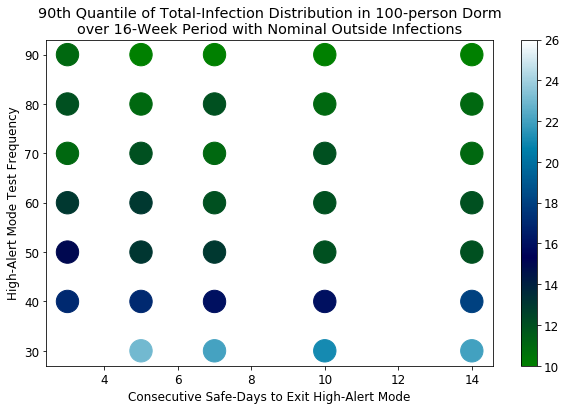

In [36]:
xs = []
ys = []
zs_inf = []
plt.rcParams.update({'font.size': 12})
for j, safe_days in enumerate(safe_days_to_exit_high_alert):
    for i, test_rate in enumerate(high_test_rates):
        xs.append(safe_days)
        ys.append(test_rate * 100)
        idx = mapping_to_idx[(contacts_per_day, base_test_rate, test_rate, safe_days)]
        zs_inf.append(np.quantile(return_dict[idx]['total_infected'], 0.9))

plt.figure(figsize=(10,6))
plt.scatter(xs, ys, c=zs_inf, s=500, cmap='ocean')
plt.colorbar()
plt.xlabel("Consecutive Safe-Days to Exit High-Alert Mode")
plt.ylabel("High-Alert Mode Test Frequency")
plt.title("90th Quantile of Total-Infection Distribution in 100-person Dorm\n"
          "over 16-Week Period with Nominal Outside Infections")

Text(0.5,1,'Average Daily Tests Performed by Adaptive High-Alert Protocol')

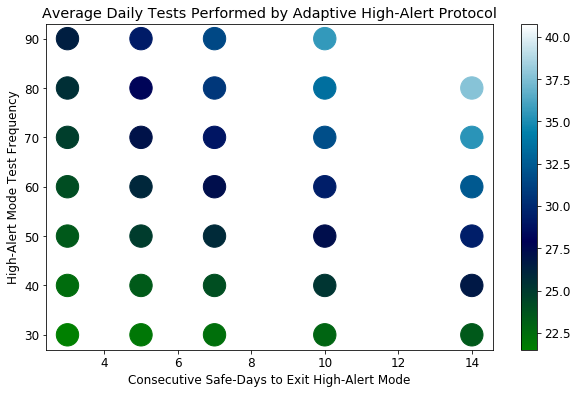

In [42]:
xs = []
ys = []
zs_test = []
for j, safe_days in enumerate(safe_days_to_exit_high_alert):
    for i, test_rate in enumerate(high_test_rates):
        idx = mapping_to_idx[(contacts_per_day, base_test_rate, test_rate, safe_days)]
           
        xs.append(safe_days)
        ys.append(test_rate*100)
        
        
        sum_avg_daily_tests = 0
        for trajectory_statuses in return_dict[idx]['high_alert_statuses']:
            high_alert_days = sum(trajectory_statuses)
        
            avg_daily_tests = high_alert_days * test_rate * 100 + (112 - high_alert_days) * base_test_rate * 100
            sum_avg_daily_tests += avg_daily_tests / 112
            
        zs_test.append(sum_avg_daily_tests / len(return_dict[idx]['high_alert_statuses']))
        
plt.figure(figsize=(10,6))
plt.scatter(xs, ys, c=zs_test, s=500, cmap='ocean')
plt.colorbar()
plt.xlabel("Consecutive Safe-Days to Exit High-Alert Mode")
plt.ylabel("High-Alert Mode Test Frequency")
plt.title("Average Daily Tests Performed by Adaptive High-Alert Protocol")

In [38]:
def get_best_params(max_test_capacity):
    idx = 0
    best_safe_days = 0
    best_test_rate = 0
    best_inf = 100
    
    for safe_days in safe_days_to_exit_high_alert:
        for test_rate in high_test_rates:
            
            if zs_test[idx] <= max_test_capacity:
                if zs_inf[idx] < best_inf:
                    best_inf = zs_inf[idx]
                    best_safe_days = safe_days
                    best_test_rate = test_rate
            idx += 1
    
    return best_safe_days, best_test_rate, best_inf

In [39]:
# investigate pareto frontier b/w test capacity and 90th quantile infections
test_capacity_range = np.linspace(min(zs_test), max(zs_test), 20)
xs_test_cap = []
ys_best_inf = []
best_protocols = []
for test_cap in test_capacity_range:
    xs_test_cap.append(test_cap)
    safe_days, test_rate, best_inf = get_best_params(test_cap)
    ys_best_inf.append(best_inf)
    best_protocols.append((safe_days, test_rate))

Text(0.5,1,'Pareto Frontier between Total Infections vs. Testing Capacity \nAssuming Nominal Outside Infections')

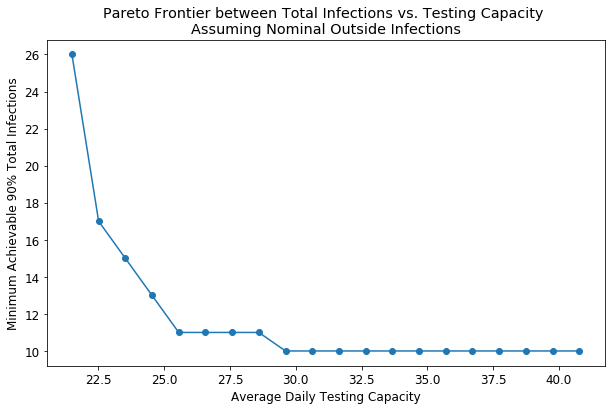

In [47]:
plt.figure(figsize=(10,6))
plt.plot(xs_test_cap, ys_best_inf, marker='o')
plt.xlabel("Average Daily Testing Capacity")
plt.ylabel("Minimum Achievable 90% Total Infections")
plt.title("Pareto Frontier between Total Infections vs. Testing Capacity \n"
         "Assuming Nominal Outside Infections")

In [43]:
best_protocols

[(3, 0.3),
 (3, 0.4),
 (3, 0.5),
 (3, 0.6),
 (3, 0.7),
 (3, 0.7),
 (3, 0.7),
 (3, 0.7),
 (5, 0.9),
 (5, 0.9),
 (5, 0.9),
 (5, 0.9),
 (5, 0.9),
 (5, 0.9),
 (5, 0.9),
 (5, 0.9),
 (5, 0.9),
 (5, 0.9),
 (5, 0.9),
 (5, 0.9)]

In [5]:
mapping_to_idx = {}
for idx in idx_mapping:
    (contacts_per_day, 
      base_test_rate,
      high_alert_test_rate, 
      safe_days) = idx_mapping[idx]
    mapping_to_idx[(contacts_per_day, 
      base_test_rate,
      high_alert_test_rate, 
      safe_days) ] = idx

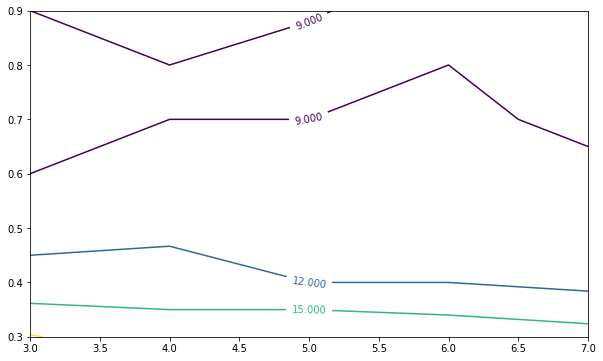

In [14]:
Y_test_rates = np.array(high_test_rates)
X_safe_days_to_exit = np.array(safe_days_to_exit_high_alert)

Z_infections = np.zeros((len(high_test_rates), len(safe_days_to_exit_high_alert)))

for j, safe_days in enumerate(X_safe_days_to_exit):
    for i, test_rate in enumerate(Y_test_rates):
        idx = mapping_to_idx[(contacts_per_day, base_test_rate, test_rate, safe_days)]
        #num_5_infections = [t for t in return_dict[idx]['total_infected'] if t >= 10]
        
        Z_infections[i,j] = np.quantile(return_dict[idx]['total_infected'], 0.8)#len(num_5_infections) / len(return_dict[idx]['total_infected']) * 100

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,6))
CS = plt.contour(X_safe_days_to_exit, Y_test_rates, Z_infections, 3)
plt.clabel(CS, inline=1, fontsize=10)
plt.show()

Text(0.5,1,'80th Quantile of Total-Infection Distribution in 100-person Dorm\nover 16-Week Period with Nominal Outside Infections\n')

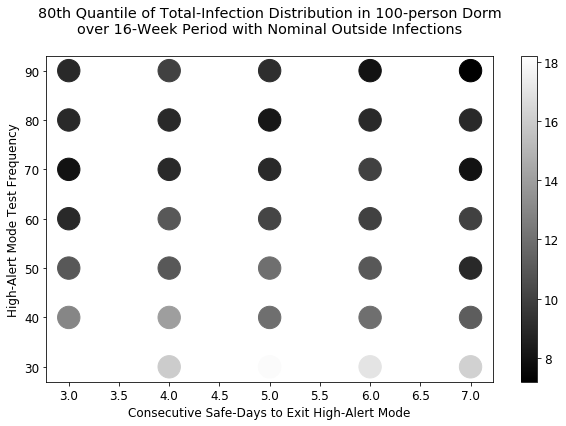

In [27]:
xs = []
ys = []
zs = []
plt.rcParams.update({'font.size': 12})
for j, safe_days in enumerate(X_safe_days_to_exit):
    for i, test_rate in enumerate(Y_test_rates):
        xs.append(safe_days)
        ys.append(test_rate * 100)
        zs.append(Z_infections[i,j])

plt.figure(figsize=(10,6))
plt.scatter(xs, ys, c=zs, s=500, cmap='gray')
plt.colorbar()
plt.xlabel("Consecutive Safe-Days to Exit High-Alert Mode")
plt.ylabel("High-Alert Mode Test Frequency")
plt.title("80th Quantile of Total-Infection Distribution in 100-person Dorm\n"
          "over 16-Week Period with Nominal Outside Infections\n")

Text(0.5,1,'Average Daily Tests Performed by Adaptive High-Alert Protocol')

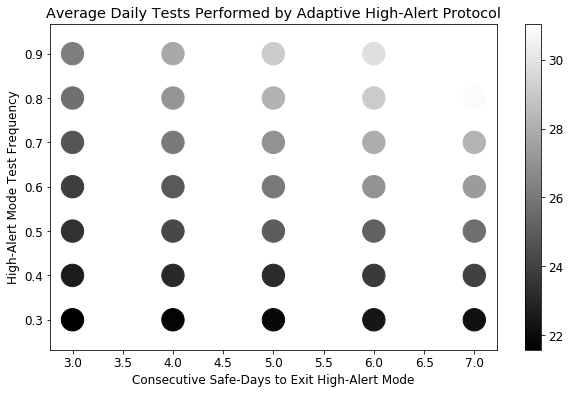

In [30]:
xs = []
ys = []
zs = []
for j, safe_days in enumerate(X_safe_days_to_exit):
    for i, test_rate in enumerate(Y_test_rates):
        idx = mapping_to_idx[(contacts_per_day, base_test_rate, test_rate, safe_days)]
           
        xs.append(safe_days)
        ys.append(test_rate)
        
        
        sum_avg_daily_tests = 0
        for trajectory_statuses in return_dict[idx]['high_alert_statuses']:
            high_alert_days = sum(trajectory_statuses)
        
            avg_daily_tests = high_alert_days * test_rate * 100 + (112 - high_alert_days) * base_test_rate * 100
            sum_avg_daily_tests += avg_daily_tests / 112
            
        zs.append(sum_avg_daily_tests / len(return_dict[idx]['high_alert_statuses']))
        
plt.figure(figsize=(10,6))
plt.scatter(xs, ys, c=zs, s=500, cmap='gray')
plt.colorbar()
plt.xlabel("Consecutive Safe-Days to Exit High-Alert Mode")
plt.ylabel("High-Alert Mode Test Frequency")
plt.title("Average Daily Tests Performed by Adaptive High-Alert Protocol")

Text(0.5,1,'distribution of total infections, with parameters:\nhigh-alert test frequency: 30%\nbaseline dorm contacts/day: 11.3')

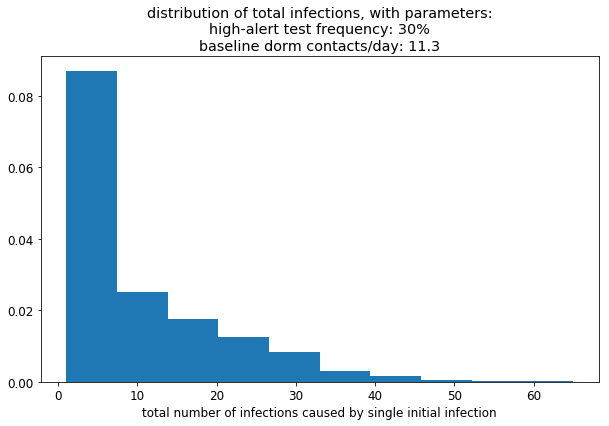

In [45]:
idx = mapping_to_idx[(11.3, 0.2, 0.3, 3)]
t = return_dict[idx]['total_infected']
plt.figure(figsize=(10,6))
plt.hist(t, normed=True)
plt.xlabel("total number of infections caused by single initial infection")
plt.title("distribution of total infections, with parameters:\n" 
          "high-alert test frequency: 30%\n"
          "baseline dorm contacts/day: 11.3")

Text(0.5,1,'distribution of total infections, with parameters:\nhigh-alert test frequency: 70%\nbaseline dorm contacts/day: 11.3')

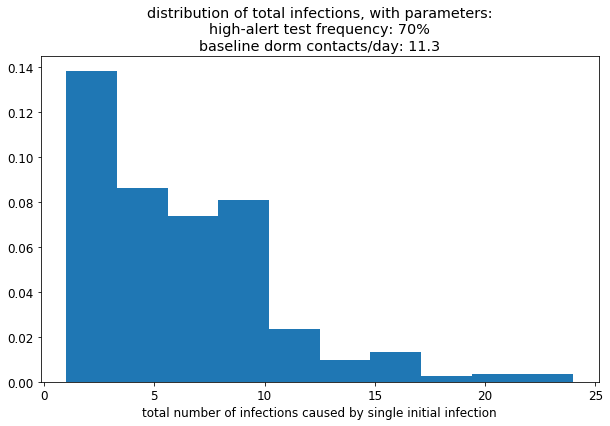

In [46]:
idx = mapping_to_idx[(11.3, 0.2, 0.7, 3)]
t = return_dict[idx]['total_infected']
plt.figure(figsize=(10,6))
plt.hist(t, normed=True)
plt.xlabel("total number of infections caused by single initial infection")
plt.title("distribution of total infections, with parameters:\n" 
          "high-alert test frequency: 70%\n"
          "baseline dorm contacts/day: 11.3")